## 『本次練習內容』
#### 搭建一個能識別驗證碼的模型(CNN+CTC)

## 『本次練習目的』
  #### 了解如何結合CNN與CTC Loss
  #### 有時間學員也可以延伸閱讀CNN+RNN+CTC模型
  #### 沒有GPU的學員可以使用Colab，可以參考問答區的文章

In [0]:
## 使用Colab可先run這裡的code
#假如要連結自己的雲端硬碟再開啟
##from google.colab import drive
##drive.mount('/content/gdrive')
#檢查GPU
##!nvidia-smi
##安裝產生驗證碼的套件

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

## 記得先 pip install captcha

In [1]:
!pip install captcha

     |████████████████████████████████| 102kB 10.7MB/s 


## 產生驗證碼

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


Text(0.5, 1.0, '0C89')

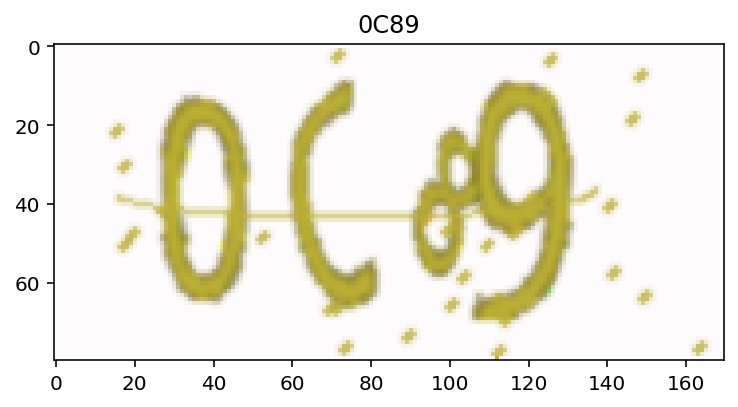

In [2]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

# while the interactive graphical user interface have unique advantages , when working with Jupyter Notebook 
# it is often more convenient to display Matplotlib-produced graphics embedded directly in the notebook.
# This behavior is activated using the IPython command %matplotlib inline , which activates the 'inline backend' provided by IPython.
# This configures Matplotlib to use a noninteractive backend to generate graphic images , which are then displayed as static images.
# The Ipython 'inline backend' for Matplotlib can be fine-tuned using the IPython %config command.

# select the output format for the generated graphic using InlineBackend.figure_format option 
# https://books.google.com.tw/books?id=AzKBDwAAQBAJ&pg=PA142&lpg=PA142&dq=%25config+InlineBackend+python&source=bl&ots=zA_tcCUWUy&sig=ACfU3U2R96Eq72mhUbNo5RU6h-K-tNWsHg&hl=zh-TW&sa=X&ved=2ahUKEwj1oKHik6boAhXTIqYKHcLYA7kQ6AEwAnoECAYQAQ#v=onepage&q=%25config%20InlineBackend%20python&f=false



%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
##驗證碼包含0-9數字以及26個英文字母
# digits是生成所有數字0-9.
# ascii_letters是生成所有字母
characters = string.digits + string.ascii_uppercase
print(characters)

##設定產生圖片尺寸，以及總類別，n_class之所以要加一是為了留一個位置(class)給Blank
width, height, n_len, n_class = 170, 80, 4, len(characters)+1 # 10 + 26 + 1

##設定產生驗證碼的generator
generator = ImageCaptcha(width=width, height=height)

##我們先練習固定長度4個字的驗證碼
# 從一個序列中隨機抽取若干元素
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)

## 自己搭建一個CNN模型使得output feature Map 高度被壓縮成小於4，8<寬度<20
#### 解答的output feature Map 為 (batch_size,1,13,32)

In [0]:
def conv_bn_max(input_tensor):
  x = input_tensor
  x = Conv2D(filters = 32 , kernel_size = (3 , 3) , padding = 'valid' , strides = (1 , 1) , activation = 'relu')(x)
  # 針對mini-batch中所有feature map做bn，所以axis是channel
  x = BatchNormalization(axis = -1 , scale = False)(x)
  x = Conv2D(filters = 32 , kernel_size = (3 , 3) , padding = 'valid' , strides = (1 , 1) , activation = 'relu')(x)
  x = BatchNormalization(axis = -1 , scale = False)(x)
  x = MaxPooling2D(pool_size = (2 , 2) , strides = (2 , 2))(x)

  return x

In [4]:
from keras import backend as K
import keras

##CTC Loss需要四個資訊，分別是
## Label
## 預測
## CNN OUTPUT寬度
## 預測影像所包含文字長度
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # 在batch上運行CTC損失算法
    # input_length:containing the sequence length(序列長度) for each batch item in y_pred.
    # label_length:containing the sequence length for each batch item in y_true.(labels)
    # Return:Tensor with shape (samples,1) containing the CTC loss of each element
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

Using TensorFlow backend.


In [13]:
from keras.models import *
from keras.layers import *
rnn_size = 128

input_tensor = Input((height,width, 3))
############################################
print(input_tensor)
############################################
x = input_tensor

'''
自己設計CNN層
'''

x = conv_bn_max(x)
x = conv_bn_max(x)
x = conv_bn_max(x)
x = conv_bn_max(x)


##記錄輸出CNN尺寸，loss部分需要這個資訊
##conv_shape=(Batch_size,輸出高度,輸出寬度,輸出深度)
conv_shape = x.get_shape()

############################################
print(conv_shape)
print(conv_shape[0])
print(conv_shape[1])
############################################



##從(Batch_size,輸出高度,輸出寬度,輸出深度)變成(Batch_size,輸出寬度,輸出深度*輸出高度)，以符合ctc loss需求
x = Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1]*conv_shape[3])))(x)
############################################
x = Dense(units = 32 , activation='relu')(x)
############################################

x = Dropout(0.25)(x)
x = Dense(n_class, activation='softmax')(x)

############################################
print(x.shape)
print(x.shape[0])
print(x.shape[1])
print(x.shape[0]*x.shape[1])
############################################

##包裝用來預測的model
base_model = Model(input=input_tensor, output=x)


##設定要給CTC Loss的資訊
# n_len:整個label長度
labels = Input(name='the_labels', shape = [n_len], dtype='float32')
# input_len:y_pred的長度
input_length = Input(name='input_length', shape = [1], dtype='int64')
label_length = Input(name='label_length', shape = [1], dtype='int64')

# 將任意表達式封裝為Layer對象。
# Lambda(function, output_shape=None, mask=None, arguments=None)
# function: 需要封裝的函數
loss_out = Lambda(ctc_lambda_func , output_shape=(1,), 
                  name='ctc')([x, labels, input_length, label_length])

##這裡的model是用來計算loss
model = Model(inputs = [input_tensor, labels, input_length, label_length], outputs = [loss_out])

##之所以要lambda y_true, y_pred: y_pred是因為我們的loss已經包在網路裡，會output:y_true, y_pred，而我們只需要y_pred
# 最後一層由loss_out所構成的layer輸出一個loss叫做y_pred(因為是model的一部分)，整個model輸出的loss叫做y_true(為整張驗證碼圖片的loss)
# 但我們要的是為每一張驗證碼圖片切割的子圖的loss，所以選擇y_pred
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='SGD')

Tensor("input_5:0", shape=(?, 80, 170, 3), dtype=float32)
(?, 1, 6, 32)
?
1
(?, 6, 37)
?
6
?


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [7]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 80, 170, 3)   0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 78, 168, 32)  896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 78, 168, 32)  96          conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 76, 166, 32)  9248        batch_normalization_9[0][0]      
____________________________________________________________________________________________

In [0]:
##設計generator產生training data
## 產生包含要給loss的資訊
## X=輸入影像
## np.ones(batch_size)*int(conv_shape[2])=CNN輸出feature Map寬度
## np.ones(batch_size)*n_len=字串長度(可浮動)

def gen(batch_size=128):
    X = np.zeros((batch_size,height, width, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    while True:
        generator = ImageCaptcha(width=width, height=height)
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = np.array(generator.generate_image(random_str))
            # str.find(sub[, start[, end]])
            # This function returns the lowest index in the string where substring “sub” is found within the slice s[start:end].
            # 找尋label在(random_str)在characters中的index
            # random_str每次都會因為''而重置
            y[i] = [characters.find(x) for x in random_str]
        # yield 相當於return
        # np.ones(batch_size)是一維tensor，所以這裡是紀錄mini-batch中每個驗證碼圖片的寬度(依model設計)
        # np.ones(batch_size)*n_len , mini-batch中每個驗證碼label的長度
        yield [X, y,np.ones(batch_size)*int(conv_shape[2]), np.ones(batch_size)*n_len], np.ones(batch_size)

Label:  [[ 1  5 18 26]]
CNN輸出寬度:  [6.]
字串長度(可浮動):  [4.]


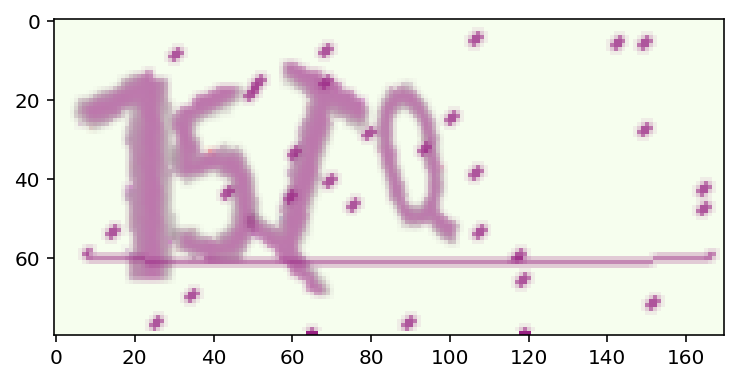

In [10]:
next_ge=gen(batch_size=1)
# 從next_ge這個generator取出element
test_ge=next(next_ge)
# [0][0]對應到X ，最後一個0是X[i]
plt.imshow(test_ge[0][0][0])
print('Label: ',test_ge[0][1])
print('CNN輸出寬度: ',test_ge[0][2])
print('字串長度(可浮動): ',test_ge[0][3])

## 開始訓練

In [14]:
# 當生成器返回steps_per_epoch次數據時計一個epoch結束，執行下一個epoch
model.fit_generator(gen(32), steps_per_epoch=300, epochs=30)



Epoch 1/30
300/300 [==============================] - 53s 176ms/step - loss: 15.0987
Epoch 2/30
300/300 [==============================] - 44s 147ms/step - loss: 12.5002
Epoch 3/30
300/300 [==============================] - 45s 149ms/step - loss: 9.7777
Epoch 4/30
300/300 [==============================] - 45s 149ms/step - loss: 8.2395
Epoch 5/30
300/300 [==============================] - 45s 150ms/step - loss: 7.3244
Epoch 6/30
300/300 [==============================] - 45s 150ms/step - loss: 6.8109
Epoch 7/30
300/300 [==============================] - 45s 150ms/step - loss: 6.4543
Epoch 8/30
300/300 [==============================] - 45s 150ms/step - loss: 6.1573
Epoch 9/30
300/300 [==============================] - 45s 150ms/step - loss: 5.9492
Epoch 10/30
300/300 [==============================] - 45s 151ms/step - loss: 5.7868
Epoch 11/30
300/300 [==============================] - 46s 152ms/step - loss: 5.4509
Epoch 12/30
300/300 [==============================] - 45s 149ms/step 

## 預測

(1, 6, 37)
6
([<tf.Tensor 'SparseToDense_5:0' shape=(1, 4) dtype=int64>], <tf.Tensor 'CTCGreedyDecoder_5:3' shape=(1, 1) dtype=float32>)


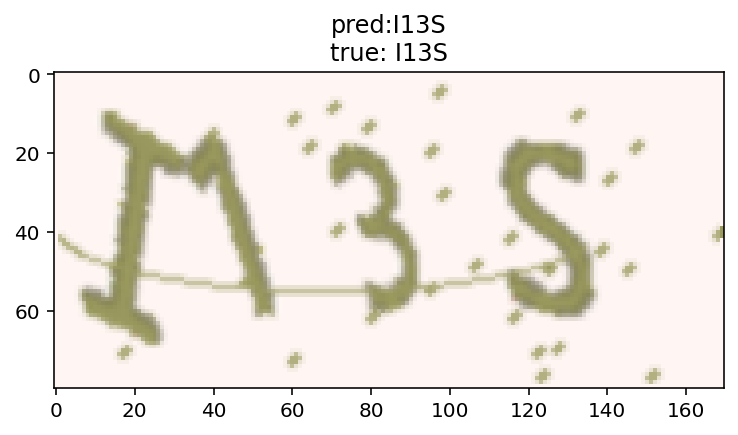

In [21]:
characters2 = characters + ' '
[X_test, y_test, _, _], _  = next(gen(1))
y_pred = base_model.predict(X_test)

#########################################
print(y_pred.shape)
print(y_pred.shape[1])
#########################################
##用ctc_decode得到解答，自己寫可以參考下方
# y_pred.shape[0]是batch_size
# y_pred.shape[1]是輸出寬度
# y_pred: tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.
# input_length: tensor (samples, ) containing the sequence length for each batch item in y_pred
# Return(for ctc_decode): Tuple/List: if greedy is true, returns a list of one element that contains the decoded sequence
# 使用貪婪算法或帶約束的字典搜索算法解碼softmax的輸出
# 返回值：形如(samples，time_steps，num_catgories)的張量，包含了路徑可能性（以softmax概率的形式）。
# 注意仍然需要一個用來取出argmax和處理空白標籤的函數
###########################################################################
print(K.ctc_decode(y_pred, input_length= np.ones(y_pred.shape[0])* y_pred.shape[1], ))
###########################################################################
# 第一個index是sample(編號幾的圖)
# 第二個index是該編號的label(長度是4)
out = K.get_value(K.ctc_decode(y_pred, input_length= np.ones(y_pred.shape[0])* y_pred.shape[1], )[0][0])
out = ''.join([characters[x] for x in out[0]])
# y_test是label
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0])
plt.title('pred:' + str(out) + '\ntrue: ' + str(y_true))

# argmax:Returns the indices of the maximum values along an axis.
argmax = np.argmax(y_pred, axis=2)[0]

## 自己寫 decode CTC

In [23]:
## 其中0代表預測為空格，如果預測相同字符之間沒有空格要移除
word=''
n=''

print(y_pred.shape)

# y_pred[0]是sample0
# 接下來一個sample裡面有多個時間序，每個時間序又有37個class(機率)
# 因此先用y_pred[0]取出所有時間序(axis 0 變成時間序 [[]] )
# 再把axis設1是對每個時間序內部取最大值
for single_result in y_pred[0].argmax(1):
    # 36 is space
    if single_result != 36:
        if n != single_result:
            word+=characters[single_result]
    n=single_result 

(1, 6, 37)


## 額外參考：加入RNN的神經網路

In [0]:
from keras.models import *
from keras.layers import *
rnn_size = 128

input_tensor = Input((height,width, 3))
x = input_tensor
for i in range(4):
    x = Convolution2D(32, 3, 3, activation='relu')(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    x = Convolution2D(32, 3, 3, activation='relu')(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    if i <3:
        x = MaxPooling2D(pool_size=(2, 2))(x)
    else:
        x = MaxPooling2D(pool_size=(2, 1))(x)


conv_shape = x.get_shape()
x = Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1]*conv_shape[3])))(x)

x = Dense(32, activation='relu')(x)

gru_1 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
             init='he_normal', name='gru1_b')(x)
gru1_merged = keras.layers.add([gru_1, gru_1b])

gru_2 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
             init='he_normal', name='gru2_b')(gru1_merged)
x = keras.layers.Concatenate()([gru_2, gru_2b])

x = Dropout(0.25)(x)
x = Dense(n_class, init='he_normal', activation='softmax')(x)

base_model = Model(input=input_tensor, output=x)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), 
                  name='ctc')([x, labels, input_length, label_length])

model = Model(input=[input_tensor, labels, input_length, label_length], output=[loss_out])
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='Adam')

/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  
/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, name="gru1", kernel_initializer="he_normal")`
/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, go_backwards=True, name="gru1_b", kernel_initializer="he_normal")`
/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 80, 170, 3)   0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 78, 168, 32)  896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 78, 168, 32)  128         conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 76, 166, 32)  9248        batch_normalization_25[0][0]     
__________________________________________________________________________________________________
batch_norm